In [68]:
import numpy as np
import pandas as pd
from collections import Counter

# cvae
import tensorflow as tf

# smote
from imblearn.over_sampling import SMOTE

# light lgb
import lightgbm as lgb
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

# graph 
import matplotlib.pyplot as plt 

In [3]:
#### 데이터 불러오기 (BBB dataset)
x_train=pd.read_csv("C:/Users/ambers/Desktop/기계학습/기계학습 과제2/데이터/X_train.csv")
y_train=pd.read_csv("C:/Users/ambers/Desktop/기계학습/기계학습 과제2/데이터/y_train.csv")
x_external=pd.read_csv("C:/Users/ambers/Desktop/기계학습/기계학습 과제2/데이터/X_external.csv")
y_external=pd.read_csv("C:/Users/ambers/Desktop/기계학습/기계학습 과제2/데이터/y_external.csv")
# 행 번호 삭제 
x_train=x_train.iloc[:,1:]
x_external=x_external.iloc[:,1:]

In [4]:
# 분류 문제
y_train=y_train.iloc[:,2]
y_test=y_external.iloc[:,2]

In [95]:
x_train.shape

(7162, 1119)

In [31]:
# 데이터 명 변경_일부 문자로 인한 오류
# 컬럼명에 특수문자가 있는 경우에 lgb에서 오류 
import re
x_train = x_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
x_external = x_external.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [32]:
x_train.columns=list(x_train.columns[:288])+list(['nNN2'])+list(x_train.columns[289:289])+list(['nRCN2'])+list(['nArCN2'])+list(['nN2'])+list(x_train.columns[292:324])+list(['nRCHX2'])+list(x_train.columns[325:331])+list(['nCX2'])+list(x_train.columns[332:])

#####  (1) Balance the minority class of the training dataset of BBB data using conditional VAE and perform classification for the test dataset using LightGBM. 

In [115]:
input_dim=x_train.shape[1]

class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=[input_dim]),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=512, activation='relu'),
                tf.keras.layers.Dropout(rate=0.2),
                tf.keras.layers.Dense(units=256, activation='relu'),
                tf.keras.layers.Dropout(rate=0.2),
                tf.keras.layers.Dense(units=64, activation='relu'),
                tf.keras.layers.Dense(units=latent_dim + latent_dim),
            ])

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=64, activation='relu'),
                tf.keras.layers.Dropout(rate=0.2),
                tf.keras.layers.Dense(units=256, activation='relu'),
                tf.keras.layers.Dropout(rate=0.2),
                tf.keras.layers.Dense(units=512, activation='relu'),
                tf.keras.layers.Dense(units=input_dim),
            ])

    @tf.function
    def encode(self, x, y):
        inputs = tf.concat([x, y], 1)
        mean, logvar = tf.split(self.encoder(inputs), num_or_size_splits=2, axis=1)
        stddev = 1e-8 + tf.nn.softplus(logvar)
        return mean, stddev

    def reparameterize(self, mean, stddev):
        eps = tf.random.normal(shape=mean.shape)
        z = mean + eps * stddev
        return z

    @tf.function
    def decode(self, z, y, apply_sigmoid=False):
        inputs = tf.concat([z, y], 1)
        logits = self.decoder(inputs)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [116]:
epochs = 30
latent_dim = 784
model = CVAE(latent_dim)

In [113]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def compute_loss(model, x, y):
    x = tf.reshape(x, [-1, 784])
    y = tf.reshape(y, [-1, 1])
    mean, stddev = model.encode(x, y)
    z = model.reparameterize(mean, stddev)
    x_logit = model.decode(z, y, True)
    x_logit = tf.clip_by_value(x_logit, 1e-8, 1-1e-8)

    # Loss
    marginal_likelihood = tf.reduce_sum(x * tf.math.log(x_logit) + (1 - x) * tf.math.log(1 - x_logit), axis=[1])
    loglikelihood = tf.reduce_mean(marginal_likelihood)

    kl_divergence = -0.5 * tf.reduce_sum(1 + tf.math.log(1e-8 + tf.square(stddev)) - tf.square(mean) - tf.square(stddev),
                                         axis=[1])
    kl_divergence = tf.reduce_mean(kl_divergence)

    ELBO = loglikelihood - kl_divergence
    loss = -ELBO

    return loss


@tf.function
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss


In [117]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
lr=lgb.LGBMClassifier()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(x_train_res, y_train_res.ravel())

In [38]:
clf.best_params_

{'C': 1.0}

In [42]:
lr1 = lgb.LGBMClassifier(C=1,penalty='l1', verbose=5)
lr1.fit(x_train_res, y_train_res.ravel())

[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: penalty
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: penalty
[LightGBM] [Info] Number of positive: 5453, number of negative: 5453
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.921107
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.665568
[LightGBM] [Debug] init for col-wise cost 0.007212 seconds, init for row-wise cost 0.016080 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63191
[LightGBM] [Info] Number of data points in the train set: 10906, number of used features: 956
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and 

LGBMClassifier(C=1, penalty='l1', verbose=5)

In [43]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the train dataset: 96.31395562075922%


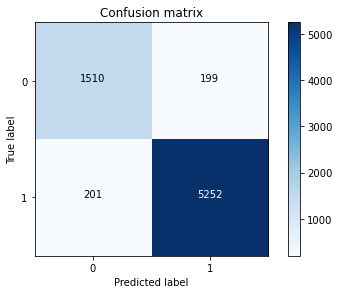

In [46]:
y_train_pre = lr1.predict(x_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 84.61538461538461%


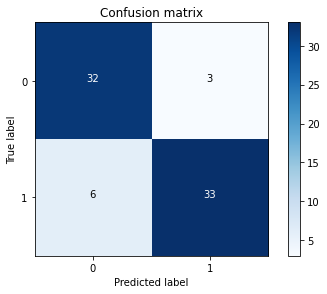

In [47]:
y_pre = lr1.predict(x_external)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

##### (2) Balance the minority class of the training dataset of BBB data using SMOTE and perform classification for the test dataset using LightGBM. 

In [33]:
print('Shape of X: {}'.format(x_train.shape))
print('Shape of y: {}'.format(y_train.shape))

print('Shape of X: {}'.format(x_external.shape))
print('Shape of y: {}'.format(y_test.shape))

Shape of X: (7162, 1119)
Shape of y: (7162,)
Shape of X: (74, 1119)
Shape of y: (74,)


In [34]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 5453
Before OverSampling, counts of label '0': 1709 

After OverSampling, the shape of train_X: (10906, 1119)
After OverSampling, the shape of train_y: (10906,) 

After OverSampling, counts of label '1': 5453
After OverSampling, counts of label '0': 5453


In [35]:
model=lgb.LGBMClassifier()

In [36]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, x_train_res, y_train_res, scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC: %.3f' % np.mean(scores))

In [39]:
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.979


In [37]:
parameters = {
    'C': np.linspace(1, 10, 10)
             }

lr=lgb.LGBMClassifier()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(x_train_res, y_train_res.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=5)

In [38]:
clf.best_params_

{'C': 1.0}

In [42]:
lr1 = lgb.LGBMClassifier(C=1,penalty='l1', verbose=5)
lr1.fit(x_train_res, y_train_res.ravel())

[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: penalty
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: penalty
[LightGBM] [Info] Number of positive: 5453, number of negative: 5453
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.921107
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.665568
[LightGBM] [Debug] init for col-wise cost 0.007212 seconds, init for row-wise cost 0.016080 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63191
[LightGBM] [Info] Number of data points in the train set: 10906, number of used features: 956
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and 

LGBMClassifier(C=1, penalty='l1', verbose=5)

In [43]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the train dataset: 96.31395562075922%


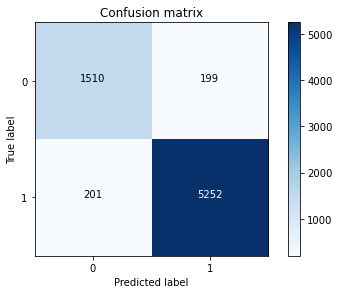

In [46]:
y_train_pre = lr1.predict(x_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 84.61538461538461%


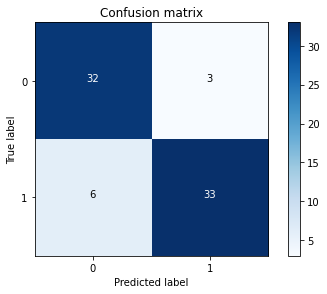

In [47]:
y_pre = lr1.predict(x_external)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [50]:
tmp = lr1.fit(x_train_res, y_train_res.ravel())

[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: penalty
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: penalty
[LightGBM] [Info] Number of positive: 5453, number of negative: 5453
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.921107
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.665568
[LightGBM] [Debug] init for col-wise cost 0.008269 seconds, init for row-wise cost 0.015680 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63191
[LightGBM] [Info] Number of data points in the train set: 10906, number of used features: 956
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and 

In [65]:
y_pred_sample_score = tmp.predict_proba(x_external)

print('Prob[0]: %.3f' % y_pred_sample_score[0][0])
print('Prob[1]: %.3f' % y_pred_sample_score[0][1])

Prob[0]: 0.149
Prob[1]: 0.851
